In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt

In [40]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# 0. Первый взгляд

In [41]:
df = pd.read_csv("Задание 3 LTV.csv")

In [42]:
# Названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer                       9134 non-null   object 
 1   state                          9134 non-null   object 
 2   customer lifetime value        9134 non-null   float64
 3   response                       9134 non-null   object 
 4   coverage                       9134 non-null   object 
 5   education                      9134 non-null   object 
 6   effective to date              9134 non-null   object 
 7   employmentstatus               9134 non-null   object 
 8   gender                         9134 non-null   object 
 9   income                         9134 non-null   int64  
 10  location code                  9134 non-null   object 
 11  marital status                 9134 non-null   object 
 12  monthly premium auto           9134 non-null   i

In [44]:
df.head(3)

,customer,state,customer lifetime value,response,coverage,education,effective to date,employmentstatus,gender,income,...,months since policy inception,number of open complaints,number of policies,policy type,policy,renew offer type,sales channel,total claim amount,vehicle class,vehicle size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize


In [45]:
df.shape

(9134, 24)

In [46]:
# Дубликаты строк
df.duplicated().sum()

0

In [47]:
df['customer'].nunique()

9134

- В данных нет пропусков и дублей
- Не будем использовать столбец `customer` поскольку в нём каждая запись уникальна
- Целевая переменная - `customer lifetime value`

# 1. Немного графиков

## 1.1 Качественные переменные

In [48]:
# Разобьем категорильные переменные на два списка для оптимизации читабельности графиков
cat_cols1 = ['state', 'response', 'coverage', 'education', 'employmentstatus', 'gender', 'location code', 
            'marital status', 'policy type', 'renew offer type', 'sales channel', 'vehicle size']
cat_cols2 = ['effective to date', 'number of policies', 'policy', 'vehicle class']

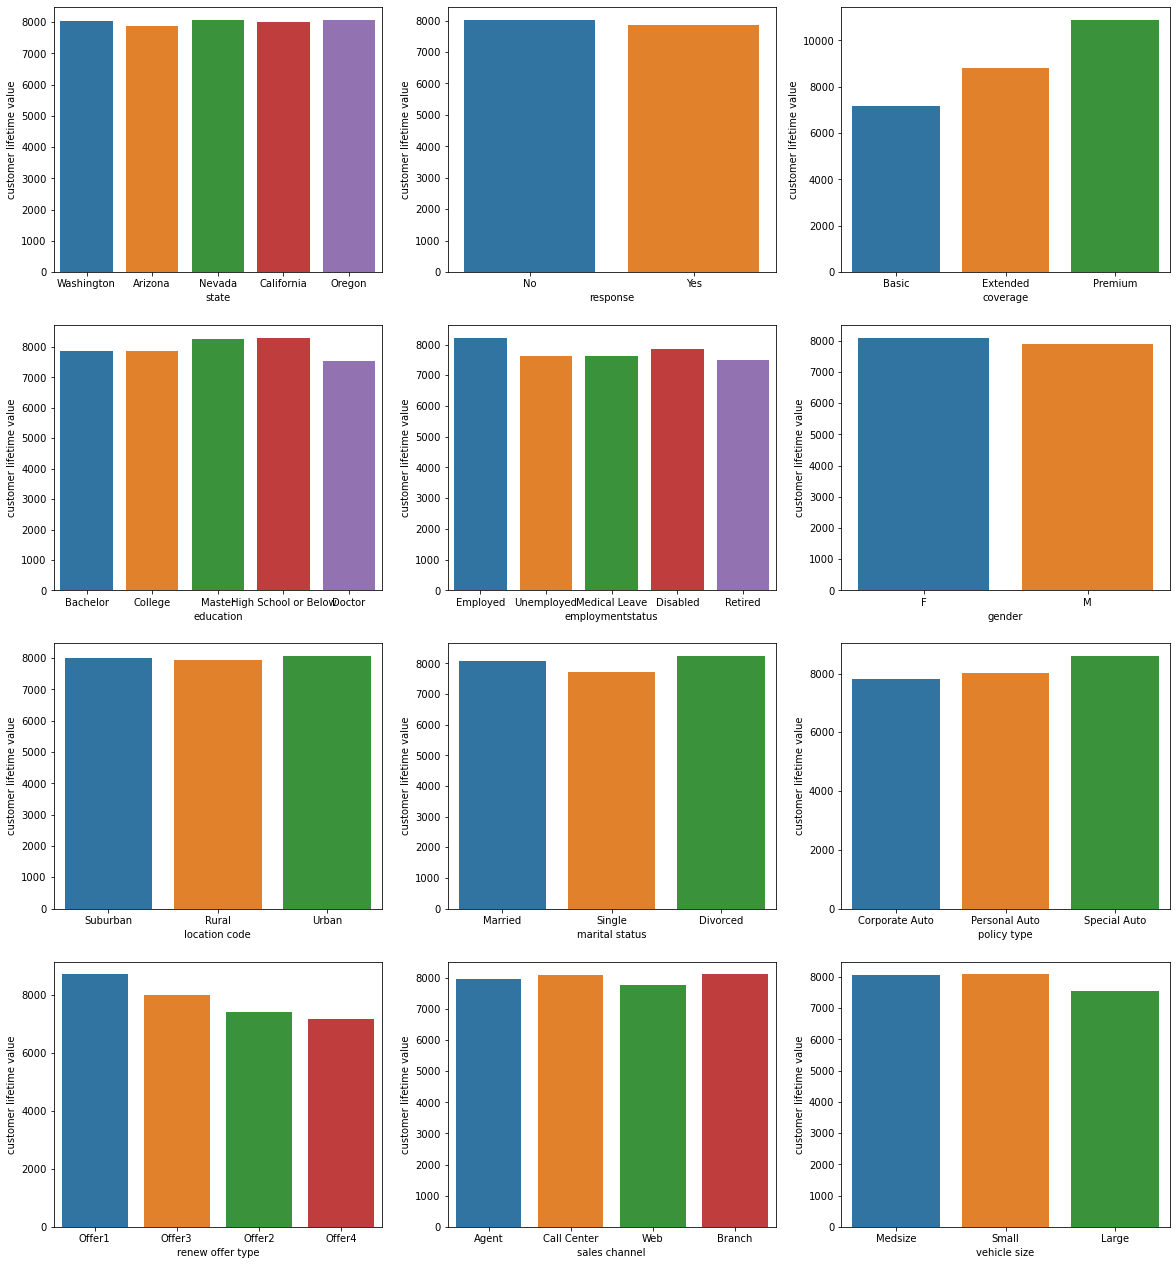

In [49]:
plt.figure(figsize=(20, 40))

for i in range(len(cat_cols1)):
    plt.subplots_adjust(hspace=.2)
    plt.subplot(7, 3, i+1)
    sns.barplot(x = cat_cols1[i], y='customer lifetime value', data=df, ci=None)
    
plt.show()

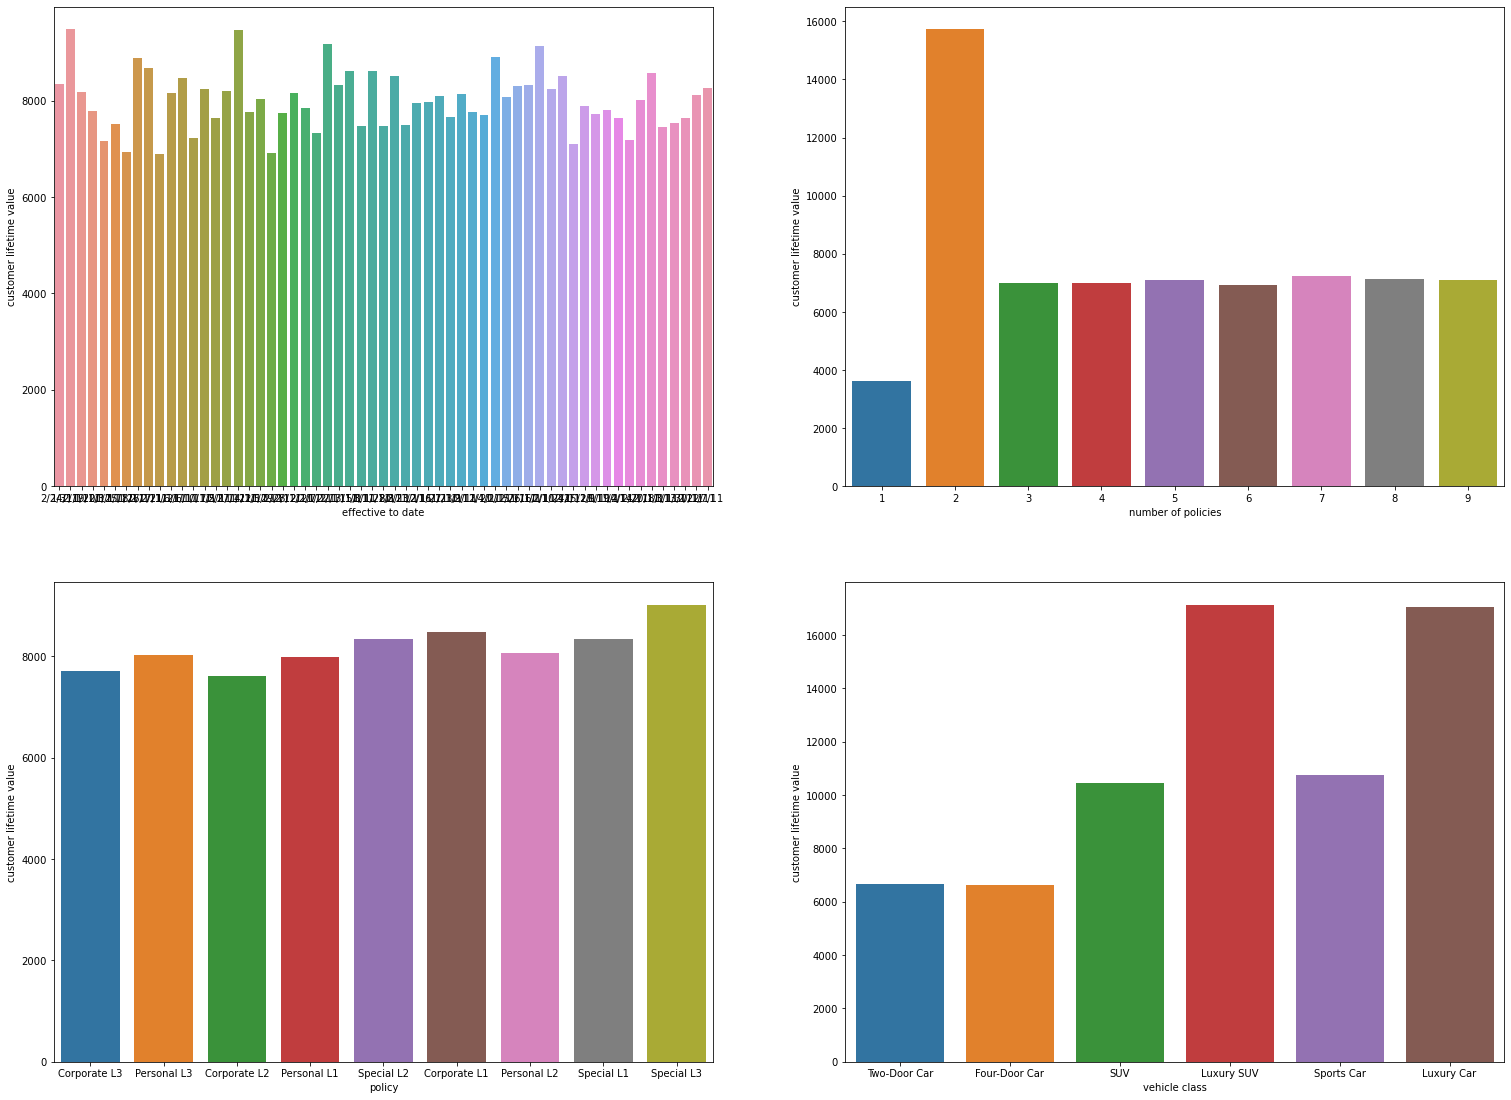

In [50]:
plt.figure(figsize=(26, 30))

for i in range(len(cat_cols2)):
    plt.subplot(3, 2, i+1)
    sns.barplot(x = cat_cols2[i], y='customer lifetime value', data=df, ci=None)
    
plt.show()

- Судя по графикам: чем выше "статус" страховки `coverage` тем выше LTV
- Каждый последующий тип оффера `renew offer type` приносит меньше денег
- Пользователи с одним и двумя полисами `number of policies` выделяются на фоне остальных
- `vehicle class` Luxury SUV и Luxury Car наиболее прибыльные

## 1.2 Колличественные переменные

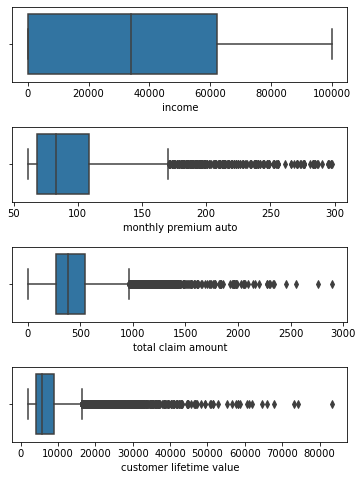

In [51]:
cont_cols1 = ['income','monthly premium auto','total claim amount', 'customer lifetime value']

plt.figure(figsize=(6, 8))
plt.subplots_adjust(hspace=.6)

for i in range(len(cont_cols1)):
    plt.subplot(4, 1, i+1)
    sns.boxplot(x=df[cont_cols1[i]])
    
plt.show()

- В столбцах `monthly premium auto` и `total claim amount`, а так же в целевой переменной `customer lifetime value`присутствуют выбросы. Но избавляться от них пока мы не будем, чтобы не терять данные о пользователях

In [52]:
cont_cols2 = ['months since last claim', 'months since policy inception', 'number of open complaints']

In [53]:
df['number of open complaints'].value_counts()

0    7252
1    1011
2     374
3     292
4     149
5      56
Name: number of open complaints, dtype: int64

In [54]:
df['months since policy inception'].nunique()

100

In [55]:
df['months since last claim'].nunique()

36

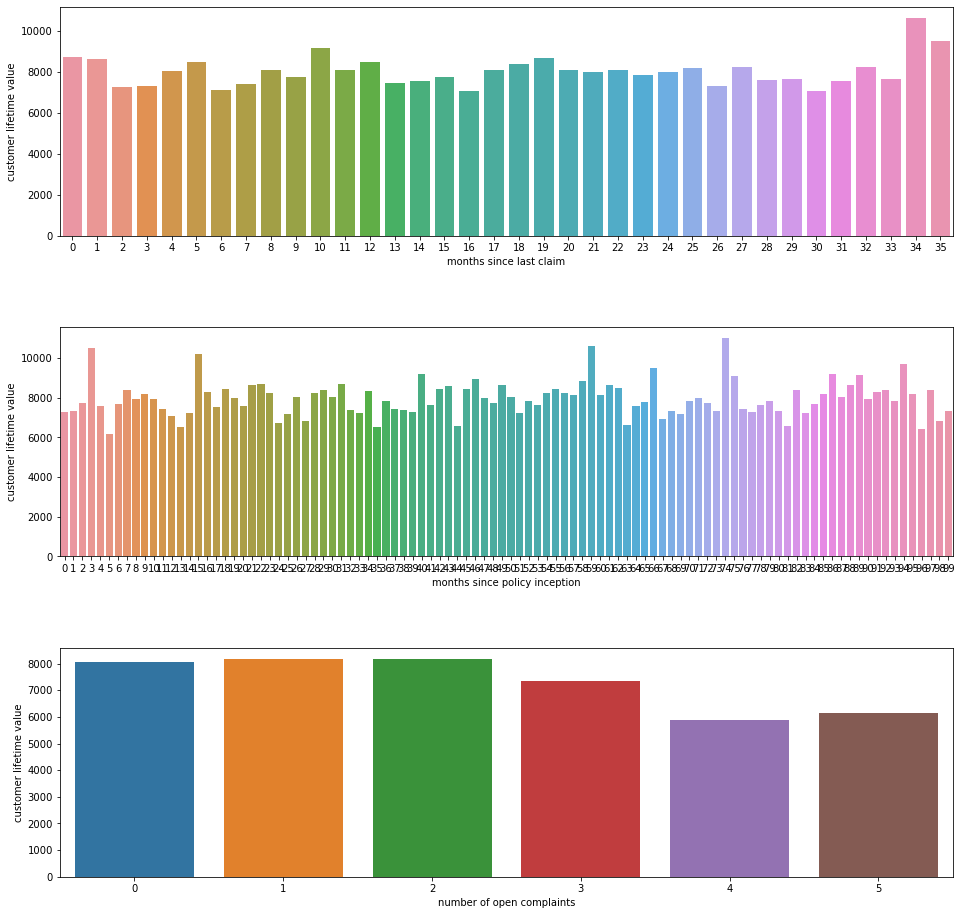

In [56]:
plt.figure(figsize=(16, 16))

for i in range(len(cont_cols2)):
    plt.subplot(3, 1, i+1)
    plt.subplots_adjust(hspace=.4)
    sns.barplot(x = cont_cols2[i], y='customer lifetime value', data = df, ci=None)
    
plt.show()

- Вероятно при увеличении числа `number of open complaints` уменьшается LTV

# 2. Статистический анализ данных

In [57]:
# Проверка на нормальность распределения целевой переменной
stat, p = stats.shapiro(df['customer lifetime value'].sample(5000)) 
p

0.0

In [58]:
# Бокс-Кокс преобразование
after_boxcox = stats.boxcox(df['customer lifetime value'])[0][:5000]
stat, p = stats.shapiro(after_boxcox) 
p

7.447530887691178e-24

Ввиду наличия выбросов в столбце с целевой переменной, которые мы решили оставить, распределение не подчиняется нормальному закону (даже после преобразования `Бокса-Кокса`).
<td>Это может сказаться на релузьтатах дальнейших статистических тестов ввиду распространённого требования тестами нормальности исследуемых признаков, поэтому необходимо правильно подбирать статистические тесты.</td>

## 2.1 Coverage

- Исследуем при уровне значимости `p=0.05` LTV пользователей разделённых по принципу принадлежности к различному типу страхового покрытия, проверив `нулевую гипотезу` о том, что группы имеют одинаковое распределение.
- `Альтернативная гипотеза`: распределение хотя бы одной группы отличается от остальных.
- Так как мы имеем дело с данными не распределёнными по нормальному закону будем использовать `Критерий Краскела-Уоллиса` 

In [59]:
basic = df[df['coverage'] == 'Basic']['customer lifetime value']
extended = df[df['coverage'] == 'Extended']['customer lifetime value']
premium = df[df['coverage'] == 'Premium']['customer lifetime value']

In [60]:
stat, p = stats.kruskal(basic, extended, premium)
p

7.648852917746348e-110

Полученное p-значение меньше установленного уровня значимости => мы имеем основания отклонить нулевую гипотезу об одинаковом распределении исследуемых величин

# 2.2 Остальные категориальные переменные

Напишем код для рассчёта p-value для остальных категориальных переменных
<td>Будем так же использовать Критерий Краскела-Уоллиса</td>

In [61]:
# Добавим в список number of open complaints, ввиду малой вариативности признака, а так же отбросим две переменные
cat_cols = cat_cols1 + cat_cols2
cat_cols.append('number of open complaints')
cat_cols.remove('effective to date')
cat_cols.remove('coverage')

In [62]:
# Каждый категориальный столбцец разобьем на группы и рассчитаем для них p-value
for i in cat_cols:
    groups = []
    for j in df[i].unique():  
        new_group = df[df[i] == j]['customer lifetime value'].tolist()
        groups.append(new_group.copy())
    
    new_p = stats.kruskal(*groups)[1]
    
    # Выведем на печать столбцы со значимыми отличиями в группах
    if new_p < 0.05:
        print(f'{i}, p={new_p}')

education, p=0.015693004298603028
employmentstatus, p=1.2758458797542519e-08
marital status, p=2.9009146434700455e-05
renew offer type, p=2.196144881912684e-36
vehicle size, p=0.00837505335446059
number of policies, p=0.0
vehicle class, p=3.309676344717952e-281
number of open complaints, p=2.1564409504417123e-05


- Таким образом при разбиении пользователей на группы по признакам: `coverage`, `education`, `employmentstatus`, `marital status`,
`renew offer type`, `vehicle size`, `number of policies`, `vehicle class`, `number of open complaints` наблюдаются значимые различия между подгруппами

# 2.3 Колличественные переменные

Оценим корреляцию признаков с LTV
<td>Целевой признак распределён не по нормальному закону, поэтому будем использовать ранговую корреляцию Спирмана</td>

In [63]:
cont_cols = cont_cols1 + cont_cols2 

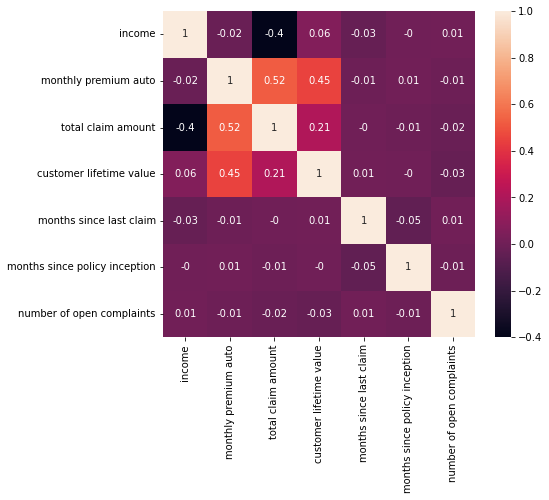

In [64]:
plt.figure(figsize=(7, 6))
sns.heatmap(df[cont_cols].corr(method='spearman').round(decimals=2), annot=True)
plt.show()

Проверим p-value коэфициентов корреляции и сравним их с пороговым значением <b>&alpha;</b> = 0.05

In [65]:
stats.spearmanr(df['total claim amount'], df['customer lifetime value'])

SpearmanrResult(correlation=0.21059795825206123, pvalue=4.351847002635894e-92)

In [66]:
stats.spearmanr(df['monthly premium auto'], df['customer lifetime value'])

SpearmanrResult(correlation=0.4539328689760404, pvalue=0.0)

Наиболее коррелируют с `LTV` - `total claim amount` и `monthly premium auto`. Корреляция статистически значима

<h2>Выводы:</h2>
- Признаки которые имеют высокий потенциал для предсказания customer lifetime value:
<br><b>coverage, education, employmentstatus, marital status, renew offer type, vehicle size, number of policies, vehicle class, number of open complaints, total claim amount и monthly premium auto</b></br>
<br>- В признаках <b>monthly premium auto, total claim amount, customer lifetime value</b> много выделяющихся значений (выбросов)</br>
<br>- Каждый последующий тип оффера <b>renew offer type</b> приносит меньше денег</br>
<br>- Пользователи с одним и двумя полисами <b>number of policies</b> выделяются на фоне остальных</br>
<br>- Пользователи с классом автомобилей (<b>vehicle class</b>) Luxury SUV и Luxury Car наиболее прибыльные</br>

# 3. Baseline моделька

#### Для построения модели предсказания LTV пользователей возьмём из исходного датафрейма отобранные ранее столбцы

In [67]:
y = df['customer lifetime value']

In [68]:
X = df[['coverage', 'education', 'employmentstatus', 'marital status', 'renew offer type', 'vehicle size', 
        'number of policies', 'vehicle class', 'number of open complaints', 'total claim amount', 'monthly premium auto']]

#### Применим encoder к категориальным переменным:

In [69]:
X_1 = X.drop(['number of policies', 'number of open complaints', 'total claim amount', 'monthly premium auto'], axis=1)

In [70]:
X_2 = X[['number of policies', 'number of open complaints', 'total claim amount', 'monthly premium auto']]

In [71]:
le = preprocessing.LabelEncoder()

In [72]:
X = pd.concat([X_1.apply(le.fit_transform), X_2], axis=1)

#### Логарифмируем признаки не распределённые по нормальному закону

In [73]:
X['monthly premium auto'] = np.log(X['monthly premium auto'])
X['total claim amount'] = np.log(X['total claim amount'])
y = np.log(y)

#### Разделим данные на сестовую и обучающую выборки

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

#### Обучим DecisionTreeRegressor, глубиной 5. (Подбирать гиперпараметры в рамках тестового не будем)

In [75]:
regr = DecisionTreeRegressor(max_depth=5)
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
mse = mean_squared_error(y_pred, y_test)

print('mse:', round(mse, 5))
print('log(y) среднее:', round(y.mean(), 5))

mse: 0.04398
log(y) среднее: 8.74856


Получим неплохое значение среднеквадратичной ошибки 

#### Выведем значимость признаков для нашей модели

In [76]:
importance = regr.feature_importances_
pd.DataFrame(data=[importance], columns=X.columns.tolist(), index=['importance'])

,coverage,education,employmentstatus,marital status,renew offer type,vehicle size,vehicle class,number of policies,number of open complaints,total claim amount,monthly premium auto
importance,0.0,0.0,0.002601,0.0,0.0,0.0,0.0,0.762882,0.0,0.000529,0.233988


<b>Вывод:</b>
- По результатам обучения модели наиболее значимыми признаками для предсказания LTV являются `number of policies` и `monthly premium auto`